In [100]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [101]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_submit = pd.read_csv('gender_submission.csv')

In [102]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [103]:
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [136]:
def enhance_feature(df):
    # Age
#     df['Age'][df['Age'].isnull()] = -1
#     df['Age'] = df['Age'].astype('int')

    # Age_Label
    cut_points = [-2,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df['Age_Label'] = pd.cut(df['Age'], cut_points, labels=label_names)
    df['Age_Label'] = df['Age_Label'].astype(CategoricalDtype(categories=label_names, ordered=True))
    
    # Age_Label_Id
    df['Age_Label_Id'] = df['Age_Label'].map(dict(zip(label_names, range(len(label_names)))))

    # Embarked
    df['Embarked'] = df['Embarked'].astype('category')

    # Sex
    df['Sex'] = df['Sex'].astype('category')
    
    # Sex_Id
    df['Sex_Id'] = df['Sex'].map({'male':0,'female':1}) 
    
    # Fare 
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    
    # Title
    df['Title'] = df.Name.apply(lambda x: re.search(', (\w+)', x).group(1))
    df['Title'] = df['Title'].astype('category')

    # Title_Id
    df['Title_Id'] = df['Title'].cat.codes
    
    # TtlFamMbr
    df['TtlFamMbr'] = df['Parch'] + df['SibSp']
    
    # Clean-up Age
    mean_age_by_title = df.groupby(['Title'])['Age'].mean()
    df['Age'] = df['Age'].fillna(df['Title'].map(mean_age_by_title))
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Age'] = df['Age'].astype('int64')
    
    # Clean-up Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().index[0])
    return df

In [137]:
df_train = enhance_feature(df_train)
df_test = enhance_feature(df_test)

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null category
Age             891 non-null int64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           204 non-null object
Embarked        891 non-null category
Age_Label       891 non-null category
Age_Label_Id    891 non-null int64
Sex_Id          891 non-null int64
Title           891 non-null category
Title_Id        891 non-null int8
TtlFamMbr       891 non-null int64
dtypes: category(4), float64(1), int64(9), int8(1), object(3)
memory usage: 96.2+ KB


In [120]:
df_train.Age.min(), df_train.Age.max()

(0, 80)

In [121]:
Feature_Cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_Id', 'Age_Label_Id', 'TtlFamMbr', 'Title_Id']
Target_Cols = ['Survived']

In [122]:
df_train[Feature_Cols + Target_Cols].head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_Id,Age_Label_Id,TtlFamMbr,Title_Id,Survived
0,3,22,1,0,7.2500,0,4,1,11,0
1,1,38,1,0,71.2833,1,5,1,12,1
2,3,26,0,0,7.9250,1,4,0,8,1


#### Looking at the correlation head map, "Pclass", "Title_Id", and "Sex_Id" have the strongest correlation to Survived

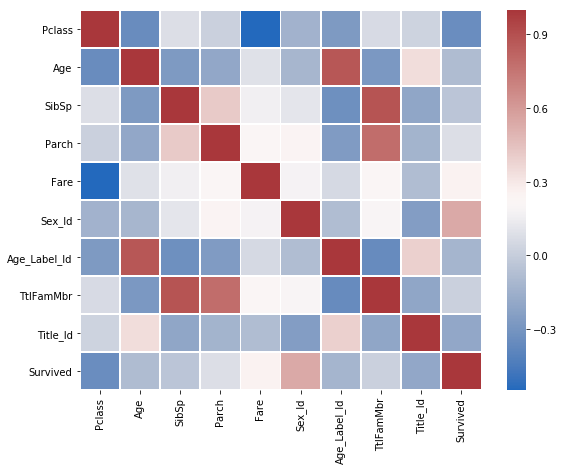

In [123]:
plt.figure(figsize=(9, 7))
sns.heatmap(df_train[Feature_Cols + Target_Cols].corr(), linewidths=0.75, cmap='vlag')

In [124]:
print('Total of columns in features:', len(Feature_Cols))

Total of columns in features: 9


#### Looking at the plots of encoded categorical values may be harder to understand unless you know what they are by heart

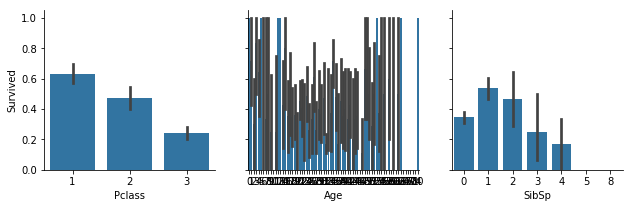

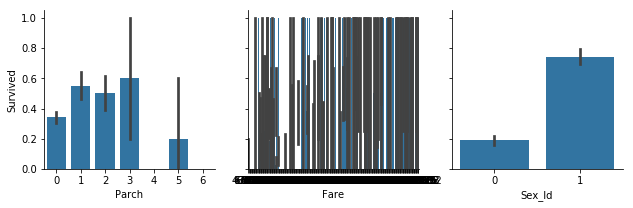

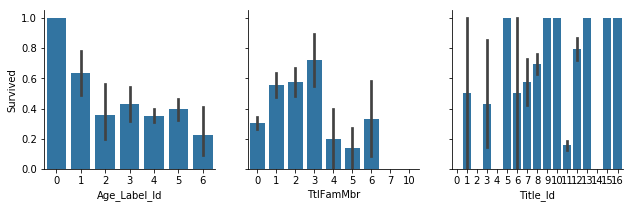

In [125]:
g = sns.PairGrid(df_train, x_vars=Feature_Cols[0:3], y_vars=Target_Cols, size=3)
g.map(sns.barplot)
g = sns.PairGrid(df_train, x_vars=Feature_Cols[3:6], y_vars=Target_Cols, size=3)
g.map(sns.barplot)
g = sns.PairGrid(df_train, x_vars=Feature_Cols[6:9], y_vars=Target_Cols, size=3)
g.map(sns.barplot)

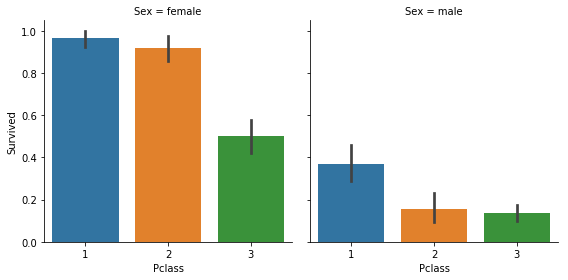

In [126]:
sns.factorplot(x='Pclass', y='Survived', col='Sex', data=df_train, kind='bar')

In [139]:
df_train[Feature_Cols + Target_Cols].to_csv('train_prepped.csv')
df_test[Feature_Cols].to_csv('test_prepped.csv')